# Diamonds - Machine Learning Project

#### Importing the necessary libraries and define formulas:

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
def colum_calcs(df):
#     df['volume'] = (df['x'] * df['y'] * df['z'])
    df['volume'] = (df['x'] * df['x'] * df['z']) / 3
    df['ratio_xy'] = df['x'] / df['y']
#     df['ratio_xz'] = ((df['x'] * df['x'])/ df['z'])

In [3]:
def diamond_shape(df):
    dshape = []
    for i in df['table'].index:
        if 54<df['table'][i]<57 and 61<df['depth'][i]<62.5:
            dshape.append('round')
        elif 52<df['table'][i]<60 and 60<df['depth'][i]<68:
            dshape.append('oval')
        elif 63<df['table'][i]<69 and 69<df['depth'][i]<76:
            dshape.append('princess')
        elif 58<df['table'][i]<63 and 58<df['depth'][i]<66:
            dshape.append('cushion')
        else:
            dshape.append('others')
    return dshape

# Based on the table in the following link: https://beyond4cs.com/grading/depth-and-table-values/

In [4]:
def convertfeatures2log(df, listvars):
    for var in listvars:
        df[var] = df[var].apply(lambda x : math.log(x))

In [5]:
def convert_catg(df):
    df['cut'] = df['cut'].map({'Fair':0,'Good':1,'Very Good':2,'Premium':3, 'Ideal':4})
    df['color'] = df['color'].map({'J':0, 'I':1, 'H':2, 'G':3, 'F': 4, 'E': 5, 'D':6})
    df['clarity'] = df['clarity'].map({'I1':0,'SI2':1,'SI1':2,'VS2':3,'VS1':4,'VVS2':5,'VVS1':6,'IF':7})
    df['shape'] = df['shape'].map({'round':4, 'oval': 1, 'princess': 3, 'cushion':2, 'others':0})

#### Import the tables

In [6]:
diamonds = pd.read_csv('data/diamonds_train.csv')


In [7]:
diamonds.corr()

,carat,depth,table,price,x,y,z
carat,1.000000,0.026528,0.183392,0.921935,0.975688,0.951667,0.967570
depth,0.026528,1.000000,-0.293114,-0.014864,-0.026348,-0.030966,0.094655
table,0.183392,-0.293114,1.000000,0.130111,0.196059,0.184673,0.155189
price,0.921935,-0.014864,0.130111,1.000000,0.885848,0.866163,0.874500
x,0.975688,-0.026348,0.196059,0.885848,1.000000,0.973712,0.984876
y,0.951667,-0.030966,0.184673,0.866163,0.973712,1.000000,0.964828
z,0.967570,0.094655,0.155189,0.874500,0.984876,0.964828,1.000000


## Exploratory Data Analysis

In [8]:
diamonds.describe()

,carat,depth,table,price,x,y,z
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,0.797706,61.752841,57.446133,3928.444469,5.729392,5.732819,3.537154
std,0.475544,1.431725,2.233535,3992.416147,1.124453,1.146650,0.697062
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,945.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2397.000000,5.690000,5.710000,3.520000
75%,1.040000,62.500000,59.000000,5331.000000,6.540000,6.540000,4.035000
max,4.500000,79.000000,95.000000,18823.000000,10.230000,58.900000,8.060000


There are zero values in x, y and z, plus it seems like there are big outliers there. We'll have to take care of that.

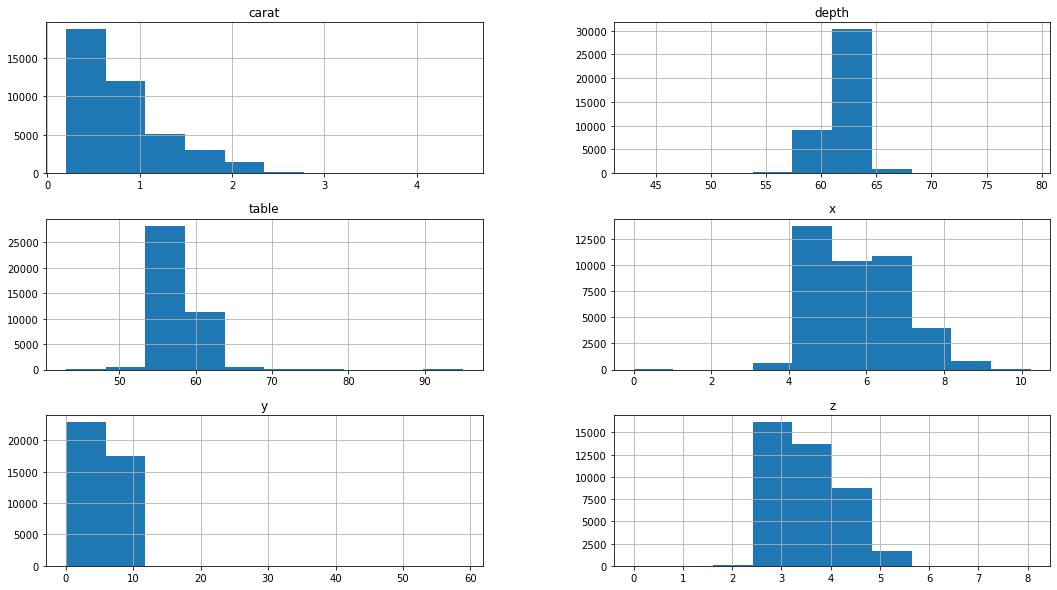

In [9]:
ghaph_vars = ['carat','depth','table','x','y','z']
diamonds.hist(ghaph_vars, figsize=(18,10));

As it can be seen, there are outliers and the shape of the distribution is not normalized.

In [10]:
diamonds.loc[((diamonds['y'] > 10) )]

,carat,cut,color,clarity,depth,table,price,x,y,z
3468,4.01,Premium,I,I1,61.0,61.0,15223,10.14,10.10,6.17
14708,2.00,Premium,H,SI2,58.9,57.0,12210,8.09,58.90,8.06
31083,4.50,Fair,J,I1,65.8,58.0,18531,10.23,10.16,6.72


In [11]:
diamonds.loc[((diamonds['z'] > 6))]

,carat,cut,color,clarity,depth,table,price,x,y,z
2884,4.00,Very Good,I,I1,63.3,58.0,15984,10.01,9.94,6.31
3468,4.01,Premium,I,I1,61.0,61.0,15223,10.14,10.10,6.17
14708,2.00,Premium,H,SI2,58.9,57.0,12210,8.09,58.90,8.06
20432,3.40,Fair,D,I1,66.8,52.0,15964,9.42,9.34,6.27
21513,3.51,Premium,J,VS2,62.5,59.0,18701,9.66,9.63,6.03
23609,4.01,Premium,J,I1,62.5,62.0,15223,10.02,9.94,6.24
27893,4.13,Fair,H,I1,64.8,61.0,17329,10.00,9.85,6.43
31083,4.50,Fair,J,I1,65.8,58.0,18531,10.23,10.16,6.72
33758,2.01,Fair,G,SI2,65.6,56.0,15562,7.89,7.84,6.16
35525,3.50,Ideal,H,I1,62.8,57.0,12587,9.65,9.59,6.03


## Data Treatment

In [12]:
diamonds.drop_duplicates(inplace=True)

In [13]:
diamonds = diamonds[(diamonds[['x','y', 'z']] != 0).all(axis=1)]
diamonds = diamonds.loc[~((diamonds['y'] > 10) | (diamonds['z'] > 6))]

In [14]:
colum_calcs(diamonds)

In [15]:
diamonds.describe()

,carat,depth,table,price,x,y,z,volume,ratio_xy
count,40341.000000,40341.000000,40341.000000,40341.000000,40341.000000,40341.00000,40341.000000,40341.000000,40341.000000
mean,0.796663,61.751997,57.446526,3924.408666,5.728759,5.73085,3.537864,43.226737,0.999406
std,0.472712,1.430403,2.233181,3985.505380,1.120183,1.11200,0.691716,25.521396,0.010364
min,0.200000,43.000000,43.000000,326.000000,3.770000,3.72000,1.070000,10.820955,0.749169
25%,0.400000,61.000000,56.000000,945.000000,4.710000,4.72000,2.910000,21.622500,0.992593
50%,0.700000,61.800000,57.000000,2396.000000,5.690000,5.71000,3.520000,38.150028,0.995726
75%,1.040000,62.500000,59.000000,5326.000000,6.540000,6.54000,4.030000,56.977668,1.006928
max,3.240000,79.000000,95.000000,18823.000000,9.540000,9.46000,5.980000,177.718597,1.615572


In [16]:
diamonds['shape'] = diamond_shape(diamonds)

In [17]:
linear_vars = ['carat']
convertfeatures2log(diamonds, linear_vars)

In [18]:
convert_catg(diamonds)

In [19]:
diamonds.head(100)

,carat,cut,color,clarity,depth,table,price,x,y,z,volume,ratio_xy,shape
0,0.190620,3,0,3,62.4,58.0,4268,6.83,6.79,4.25,66.085942,1.005891,1
1,-1.139434,2,2,3,63.0,57.0,505,4.35,4.38,2.75,17.345625,0.993151,1
2,-0.342490,0,3,4,65.5,55.0,2686,5.62,5.53,3.65,38.427687,1.016275,1
3,-0.891598,1,6,2,63.8,56.0,738,4.68,4.72,3.00,21.902400,0.991525,1
4,0.019803,4,3,2,60.5,59.0,4882,6.55,6.51,3.95,56.488292,1.006144,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.094311,0,4,1,65.3,51.0,2996,6.05,5.98,3.93,47.949275,1.011706,0
96,0.215111,3,3,6,60.4,59.0,10485,7.02,7.01,4.24,69.649632,1.001427,1
97,0.832909,4,1,1,61.8,57.0,16329,8.48,8.45,5.23,125.363797,1.003550,1
98,-1.309333,4,5,4,61.6,56.0,603,4.17,4.14,2.56,14.838528,1.007246,4


In [20]:
diamonds.describe()

,carat,cut,color,clarity,depth,table,price,x,y,z,volume,ratio_xy,shape
count,40341.000000,40341.000000,40341.000000,40341.000000,40341.000000,40341.000000,40341.000000,40341.000000,40341.00000,40341.000000,40341.000000,40341.000000,40341.000000
mean,-0.396761,2.904935,3.401527,3.051362,61.751997,57.446526,3924.408666,5.728759,5.73085,3.537864,43.226737,0.999406,1.672294
std,0.585205,1.117407,1.701162,1.647263,1.430403,2.233181,3985.505380,1.120183,1.11200,0.691716,25.521396,0.010364,1.227532
min,-1.609438,0.000000,0.000000,0.000000,43.000000,43.000000,326.000000,3.770000,3.72000,1.070000,10.820955,0.749169,0.000000
25%,-0.916291,2.000000,2.000000,2.000000,61.000000,56.000000,945.000000,4.710000,4.72000,2.910000,21.622500,0.992593,1.000000
50%,-0.356675,3.000000,3.000000,3.000000,61.800000,57.000000,2396.000000,5.690000,5.71000,3.520000,38.150028,0.995726,1.000000
75%,0.039221,4.000000,5.000000,4.000000,62.500000,59.000000,5326.000000,6.540000,6.54000,4.030000,56.977668,1.006928,2.000000
max,1.175573,4.000000,6.000000,7.000000,79.000000,95.000000,18823.000000,9.540000,9.46000,5.980000,177.718597,1.615572,4.000000


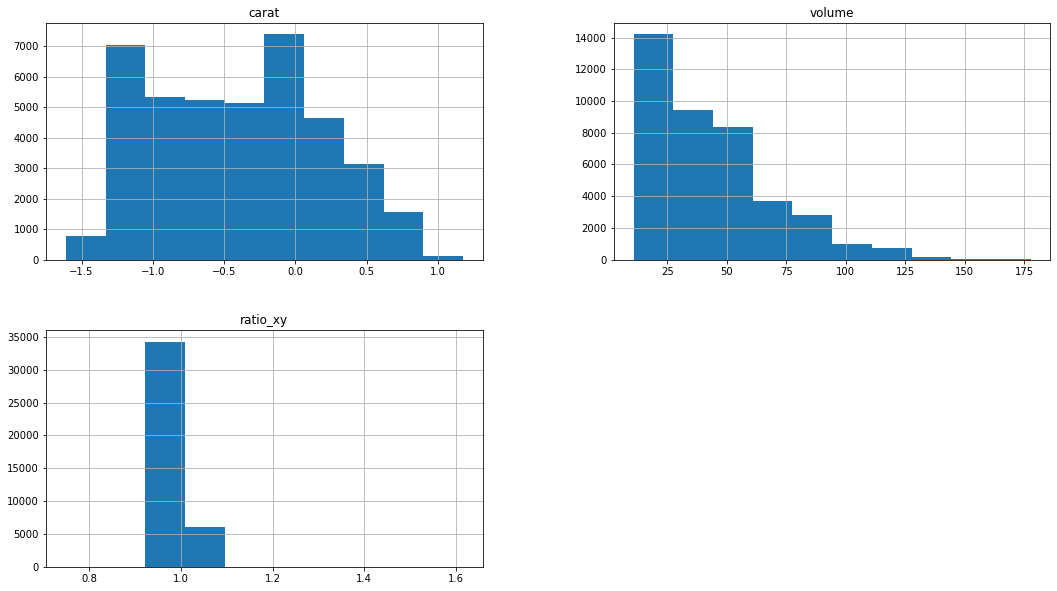

In [21]:
ghaph_vars = ['carat','volume','ratio_xy']
diamonds.hist(ghaph_vars, figsize=(18,10));

## Model Training

In [22]:
scaler = MinMaxScaler()

In [23]:
NUM_FEATS = ['carat','volume','ratio_xy']
CAT_FEATS = ['cut', 'color', 'clarity','shape']
FEATS = NUM_FEATS + CAT_FEATS
TARGET = 'price'

In [24]:
X = scaler.fit_transform(diamonds[FEATS])
y = diamonds[TARGET]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [26]:
model = lgb.LGBMRegressor()

In [27]:
scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error',cv=10)

In [28]:
np.mean(-scores)

514.8499790346306

In [29]:
param_grid = {
    'n_estimators': [ 68, 70, 72, 76, 80],
    'max_depth': [8],
    'num_leaves' : [90, 92, 95],
    'learning_rate' : [0.005, 0.1,0.2],
    'max_bin': [500,512, 600]
}


#     'num__imputer__strategy': ['mean', 'median'],
#     'n_estimators': [ 68, 70, 72, 76, 80],
#     'max_depth': [8],
#     'num_leaves' : [90, 92, 95],
#     'learning_rate' : [0.005, 0.1,0.2],
#     'max_bin': [500,512, 600]


#     'n_estimators':[ 68, 70, 72, 76, 80], 
#     'max_depth:':['auto', 8],
#     'num_leaves': [90, 92, 95],
#     'learning_rate': [0.005, 0.1,0.2],
#     'bagging_fraction': [0.70, 0.75],
#     'max_bin': [490, 495,500,512],
#     'feature_fraction' : [0.67,0.75, 1],
#     'bagging_frequency' : [0.70, 0.80, 0.85],
#     'min_data_in_leaf': [20, 25]
        
# grid_search = GridSearchCV(model, 
#                            param_grid=param_grid,
#                            cv=10, 
#                            verbose=2, 
#                            scoring='neg_root_mean_squared_error',
#                            n_jobs=-1)

grid_search = RandomizedSearchCV(model, 
                           param_distributions=param_grid,
                           cv=10, 
                           verbose=1, 
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1)

In [30]:
grid_search.fit(X, y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=LGBMRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.005, 0.1, 0.2],
                                        'max_bin': [500, 512, 600],
                                        'max_depth': [8],
                                        'n_estimators': [68, 70, 72, 76, 80],
                                        'num_leaves': [90, 92, 95]},
                   scoring='neg_root_mean_squared_error', verbose=1)

In [31]:
grid_search.best_estimator_

LGBMRegressor(max_bin=500, max_depth=8, n_estimators=68, num_leaves=90)

In [32]:
grid_search.best_score_


-512.7175020601808

In [34]:
prediction = grid_search.predict(X_test)

In [35]:
mae = mean_absolute_error(y_test,prediction)
print("Mean Absolute Error: %f" %(mae))
# Rsquare = model.score(X_test,y_test)
# print("Rsquare: %f" %(Rsquare))
rmse = mean_squared_error(y_test,prediction, squared = False)
print("Root Mean Squared Error: %f" %(rmse))

Mean Absolute Error: 237.016470
Root Mean Squared Error: 448.976104


## Prediction

In [36]:
diamonds_predict = pd.read_csv('data/diamonds_test.csv')

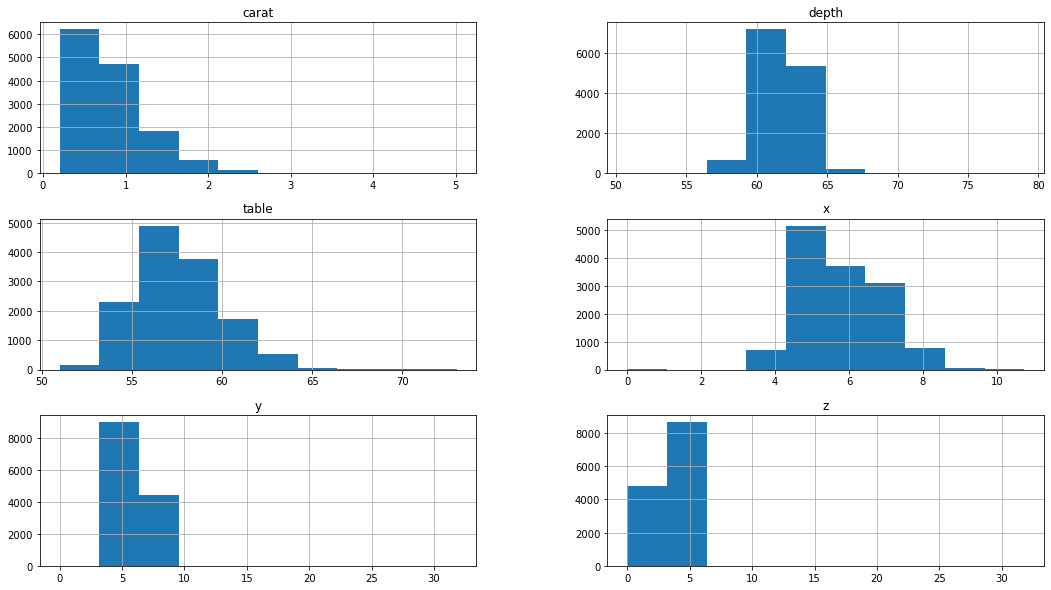

In [37]:
ghaph_vars = ['carat','depth','table','x','y','z']
diamonds_predict.hist(ghaph_vars, figsize=(18,10));

In [38]:
diamonds_predict.describe()

,id,carat,depth,table,x,y,z
count,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000
mean,6742.000000,0.798642,61.739095,57.490337,5.736454,5.739648,3.543474
std,3892.928525,0.469399,1.435310,2.237109,1.113671,1.128507,0.731005
min,0.000000,0.200000,50.800000,51.000000,0.000000,0.000000,0.000000
25%,3371.000000,0.400000,61.000000,56.000000,4.730000,4.730000,2.920000
50%,6742.000000,0.700000,61.900000,57.000000,5.700000,5.720000,3.530000
75%,10113.000000,1.040000,62.500000,59.000000,6.530000,6.530000,4.040000
max,13484.000000,5.010000,79.000000,73.000000,10.740000,31.800000,31.800000


In [39]:
diamonds_predict.loc[((diamonds_predict['y'] > 10))]

,id,carat,cut,color,clarity,depth,table,x,y,z
94,94,5.01,Fair,J,I1,65.5,59.0,10.74,10.54,6.98
1665,1665,0.51,Ideal,E,VS1,61.8,55.0,5.15,31.80,5.12


In [40]:
diamonds_predict.loc[((diamonds_predict['z'] > 6))]

,id,carat,cut,color,clarity,depth,table,x,y,z
94,94,5.01,Fair,J,I1,65.5,59.0,10.74,10.54,6.98
7336,7336,0.51,Very Good,E,VS1,61.8,54.7,5.12,5.15,31.80
9838,9838,3.65,Fair,H,I1,67.1,53.0,9.53,9.48,6.38
12305,12305,3.67,Premium,I,I1,62.4,56.0,9.86,9.81,6.13


In [41]:
diamonds_predict['x'] = diamonds_predict['x'].apply(lambda x: diamonds_predict['x'].median() if x==0 else x)
diamonds_predict['y'] = diamonds_predict['y'].apply(lambda x: diamonds_predict['y'].median() if x==0 else x)
diamonds_predict['z'] = diamonds_predict['z'].apply(lambda x: diamonds_predict['z'].median() if x==0 else x)

In [42]:
diamonds_predict['y'] = diamonds_predict['y'].apply(lambda x: 5.15 if x>15 else x)
diamonds_predict['z'] = diamonds_predict['z'].apply(lambda x: diamonds_predict['z'].median() if x>7 else x)

In [43]:
colum_calcs(diamonds_predict)
diamonds_predict['shape'] = diamond_shape(diamonds_predict)
convertfeatures2log(diamonds_predict, linear_vars)
convert_catg(diamonds_predict)

In [44]:
diamonds_predict.describe()

,id,carat,cut,color,clarity,depth,table,x,y,z,volume,ratio_xy,shape
count,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000
mean,6742.000000,-0.391288,2.902039,3.420912,3.055914,61.739095,57.490337,5.737722,5.738944,3.542425,43.322220,0.999581,1.670745
std,3892.928525,0.580873,1.112801,1.700614,1.644048,1.435310,2.237109,1.110378,1.102660,0.686607,25.319041,0.010738,1.225051
min,0.000000,-1.609438,0.000000,0.000000,0.000000,50.800000,51.000000,3.730000,3.680000,1.410000,10.712933,0.958533,0.000000
25%,3371.000000,-0.916291,2.000000,2.000000,2.000000,61.000000,56.000000,4.730000,4.730000,2.920000,21.842784,0.992669,1.000000
50%,6742.000000,-0.356675,3.000000,3.000000,3.000000,61.900000,57.000000,5.700000,5.720000,3.530000,38.305050,0.995789,1.000000
75%,10113.000000,0.039221,4.000000,5.000000,4.000000,62.500000,59.000000,6.530000,6.530000,4.040000,56.890811,1.006993,2.000000
max,13484.000000,1.611436,4.000000,6.000000,7.000000,79.000000,73.000000,10.740000,10.540000,6.980000,268.375416,1.601415,4.000000


In [45]:
diamonds_predict[FEATS]

,carat,volume,ratio_xy,cut,color,clarity,shape
0,-0.235722,41.437236,0.988115,2,4,2,2
1,0.182322,64.617366,0.988389,4,0,4,1
2,0.451076,82.967436,1.008197,3,2,2,2
3,-0.105361,48.214530,0.993475,2,4,2,1
4,-0.693147,27.117658,0.992141,2,4,4,1
...,...,...,...,...,...,...,...
13480,-0.562119,31.484750,1.005639,4,5,2,4
13481,-0.342490,38.690199,0.996510,4,1,3,4
13482,-0.356675,38.903542,1.007005,4,4,4,4
13483,-0.356675,39.355875,0.993209,2,4,1,0


In [46]:
X_test = scaler.transform(diamonds_predict[FEATS])

In [47]:
prediction = grid_search.predict(X_test)

In [48]:
output = pd.DataFrame({'id': diamonds_predict['id'], 'price': prediction})

In [49]:
output.head()

,id,price
0,0,2942.473721
1,1,5679.107122
2,2,9865.746786
3,3,4090.410026
4,4,1669.821083


In [50]:
output.describe()

,id,price
count,13485.000000,13485.000000
mean,6742.000000,3948.046023
std,3892.928525,3945.773478
min,0.000000,383.746351
25%,3371.000000,950.756382
50%,6742.000000,2455.702015
75%,10113.000000,5307.371261
max,13484.000000,18225.934686


In [51]:
output.to_csv('submission.csv',index=False)